<a href="https://colab.research.google.com/github/lizjwh/groupIAI_5take2/blob/main/4%20Training%20and%20testing%20OG%20Model%20on%20our%20dataset/TransferLearning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify American Sign Language Alphabet

In this notebook we will learn how to classify american sign language alphabet using Pytorch and deep learning networks, We will use a pre-trained model from PyTorch models zoo and we will retrain the last parts of the network on our problem.
We will use the python and GPU environment in Watson studio for faster training, Without having to go anywhere else we will be able to download, explore, built, and train our model.


<img src="https://raw.githubusercontent.com/IBM/ASL-Pytorch/master/images/asl.jpg" alt="asl" width="80%%" height="80%"/>



In this notebook, we will use PyTorch to build and train a deep learning model to classify images to 29 classes (26 ASL alphabet, space, Del, and nothing) which can be used later to help Deaf peope communicate with other and maybe with computers as well. We will use a pre-trained mobile network and we will define our classifier and connect it to network, then train this classifier along with some of the last blocks of the network on our dataset.

In this notebook we will:

1- Obtain dataset from Kaggle.  
2- explore data and define transformers to preprocess images before training.  
3- define our classifier to have an output layer of 29 outputs.  
4- train the last blocks of the network along with the classifier we defined.  
5- test the model we trained.  

This notebook uses python 3.6 + GPU environment which allow us to do the whole process and train complex model in the same place which is a notebook in Watson studio.
Learn more about available environments <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/gpu-environments.html"> Watson Studio environments.</a>




# Learning Goals

In this notebook, you will learn how to:

* Download and prepare data in Watson studio.  
* Download and retrain pre-trained PyTorch models on your problem.  
* Train and test your model.

# Contents  
1- [Setting up the environment and fetching the dataset](#1.-Setting-Up-The-Environment).  <br>
2- [Explore dataset folders and show random sample](#2.-Explore-Data).  <br>
3- [preprocess images by transforms and load them to dataloaders](#3.-Process-and-load-images).  <br>
4- [Choose a pre-trained model and retrain](#4.-Customize-our-network).  <br>
5- [Try the model before any training](#5.-Try-the-model-before-any-training).   <br>
6- [Configure training parameters and start the training](#6.-Configure-training-parameters-and-start-the-training).  <br>
7- [Test your trained model on random image](#7.-Test-The-Model-After-Training).    <br>
8- [Summary and Resources](#8.-Summary-and-Resources).  <br>

# 1. Setting Up The Environment And Fetching Data

## 1.1. Set up the notebook   
#### if you are already in the notebook with GPU environment please ignore this part

We will use Watson studio to run this notebook, Watson studio is available through IBM cloud or IBM Cloud Paks For Data.

* To start you must have IBM cloud account, Get your for free <a href="https://cloud.ibm.com/registration">Here.</a>   
* From the catalog create a <a href="https://cloud.ibm.com/catalog/services/watson-studio">watson studio</a> with standard plan or more and make sure the region is dallas to enable GPU environment.  
* create a watson studio project <a href="https://www.youtube.com/watch?v=-CUi8GezG1I">see tutorial here.</a>  
* create a new notebook from watson studio with GPU support.    
    * the notebook should have a GPU support <a href="https://www.youtube.com/watch?v=RNIWtpnNBoo">click here to learn how to create a notebook with GPU support.</a>
    * Use the From URL option and use this URL: https://github.com/IBM/ASL-Pytorch/blob/master/ASL-GPU.ipynb

## 1.2. Fetching data

In this section, we will get the required missing packages, download, and unzip the dataset.

### Get Kaggle CLI and torch vision package

First, we will need to install Kaggle CLI and torch vision package, For that, we use the exclamation mark to run command in the kernel.

In [1]:
#Deleat folders if we want a refresh
'''
import shutil

shutil.rmtree('Full Mobility', ignore_errors=True)
'''

"\nimport shutil\n\nshutil.rmtree('Full Mobility', ignore_errors=True)\n"

In [2]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle
!pip install tqdm
!pip install colorama
!pip install split-folders[full]


### Download and unzip the dataset

We will use a dataset of 87.0k ASL Alphabet images (JPG) and 29 categories (26 ASL alphabet, space, Del, and nothing) offered by amarinderplasma on Kaggle. For more about the dataset <a href="https://www.kaggle.com/amarinderplasma/alphabets-sign-language"> ASL Images.</a>

* In this cell you should import your Kaggle account credentials to be able to download the data through Kaggle CLI. To get your credentials <a href="https://www.kaggle.com/docs/api">Kaggle API key.</a>
* Please note the line should be run as it is as one line to make sure all commands are started in the same kernel.

In [3]:
# download dataset and extract it
! export KAGGLE_USERNAME="emmet454" && export KAGGLE_KEY="ee00fbc0728a71f5c5f712029e3ef004" && kaggle datasets download --force --unzip emilyburt/intro-to-ai
! ls

100% 4.06G/4.08G [00:42<00:00, 84.7MB/s]
100% 4.08G/4.08G [00:42<00:00, 103MB/s] 
Dataset  sample_data


### Split dataset into train, validate and test

In [4]:
import splitfolders

In [5]:
input_folder = 'Dataset/Full Mobility/Left hand'

#split with a ratio (train, val, test)
splitfolders.ratio(input_folder, output='Full Mobility/Left hand/',
                  seed=42, ratio=(.8, .15, .05),
                  group_prefix=None)

input_folder = 'Dataset/Full Mobility/Right hand'

#split with a ratio
splitfolders.ratio(input_folder, output='Full Mobility/Right hand/',
                  seed=42, ratio=(.8, .15, .05),
                  group_prefix=None)

input_folder = 'Dataset/Restricted mobility/Left hand'

#split with a ratio
splitfolders.ratio(input_folder, output='Restricted Mobility/Left hand/',
                  seed=42, ratio=(.8, .15, .05),
                  group_prefix=None)

input_folder = 'Dataset/Restricted mobility/Right hand'

#split with a ratio
splitfolders.ratio(input_folder, output='Restricted Mobility/Right hand/',
                  seed=42, ratio=(.8, .15, .05),
                  group_prefix=None)


Copying files: 492 files [00:05, 82.29 files/s]
Copying files: 502 files [00:04, 104.48 files/s]
Copying files: 484 files [00:04, 114.79 files/s]
Copying files: 495 files [00:05, 88.44 files/s]


# 3. Process and load images

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
from torchvision import transforms, models ,datasets
from torch.utils.data import ConcatDataset

def create_dataset(root_dir):
    """
    Creates an ImageFolder dataset from the specified root directory.
    """
    data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.RandomRotation(30),
                                          transforms.RandomHorizontalFlip(p=0.3),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    dataset = datasets.ImageFolder(root_dir, transform=data_transforms)
    return dataset

def combine_datasets(root_folders):
    """
    Combines datasets from multiple root folders into one dataset.
    """
    datasets = [create_dataset(folder) for folder in root_folders]
    combined_dataset = ConcatDataset(datasets)

    # Extract class-to-index mappings from individual datasets and merge them
    class_to_idx = {}
    for dataset in datasets:
        class_to_idx.update(dataset.class_to_idx)

    return combined_dataset, class_to_idx


def main():
  #choose which folders to include in test here
    root_folders = ['/content/Restricted Mobility/Left hand/train',
                    '/content/Restricted Mobility/Right hand/train',
                    '/content/Full Mobility/Left hand/train',
                    '/content/Full Mobility/Right hand/train']

    combined_dataset, combined_dataset.class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_dataset.class_to_idx}")
    return combined_dataset

def main_val():
  #choose which folders to include in test here
    root_folders = ['/content/Restricted Mobility/Left hand/val',
                    '/content/Restricted Mobility/Right hand/val',
                    '/content/Full Mobility/Left hand/val',
                    '/content/Full Mobility/Right hand/val']

    combined_dataset, combined_dataset.class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_dataset.class_to_idx}")
    return combined_dataset

def main_test():
  #choose which folders to include in test here
    root_folders = ['/content/Restricted Mobility/Left hand/test',
                    '/content/Restricted Mobility/Right hand/test',
                    '/content/Full Mobility/Left hand/test',
                    '/content/Full Mobility/Right hand/test']

    combined_dataset, combined_dataset.class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_dataset.class_to_idx}")
    return combined_dataset

combined_train_dataset = main()
combined_val_dataset = main_val()
combined_test_dataset = main_test()

Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'Space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'Space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'Space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


# 4. Customize our network

## 4.1. Choose a Pretrained model
choose a pre-trained model you think would have good accuracy for the problem and freeze all layers to make sure not all the network is trained during the training process.   
A list of Pytorch model zoo can be found <a href="https://pytorch.org/docs/stable/torchvision/models.html">here.</a>  
We will also print the model classifier to check the number of input neurons to consider when creating our classifier.

In [52]:
model = models.mobilenet_v2(pretrained=True)
# Freeze parameters of the tarined network
for param in model.parameters():
    param.requires_grad = False


# choose your loss function
criterion = nn.NLLLoss()


Layer: features.0.0.weight, Requires Grad: False
Layer: features.0.1.weight, Requires Grad: False
Layer: features.0.1.bias, Requires Grad: False
Layer: features.1.conv.0.0.weight, Requires Grad: False
Layer: features.1.conv.0.1.weight, Requires Grad: False
Layer: features.1.conv.0.1.bias, Requires Grad: False
Layer: features.1.conv.1.weight, Requires Grad: False
Layer: features.1.conv.2.weight, Requires Grad: False
Layer: features.1.conv.2.bias, Requires Grad: False
Layer: features.2.conv.0.0.weight, Requires Grad: False
Layer: features.2.conv.0.1.weight, Requires Grad: False
Layer: features.2.conv.0.1.bias, Requires Grad: False
Layer: features.2.conv.1.0.weight, Requires Grad: False
Layer: features.2.conv.1.1.weight, Requires Grad: False
Layer: features.2.conv.1.1.bias, Requires Grad: False
Layer: features.2.conv.2.weight, Requires Grad: False
Layer: features.2.conv.3.weight, Requires Grad: False
Layer: features.2.conv.3.bias, Requires Grad: False
Layer: features.3.conv.0.0.weight, Re

## 4.2. Choose which layers to train
In the next cell, we will unfreeze some of the last blocks of our network and we will define our custom classifier to have 29 outputs then we will attach it to the model.  
We will also choose the optimizer we want and define the learning rate for it.

In [55]:
!git clone https://github.com/lizjwh/groupIAI_5take2

# Define device (assuming you want to use GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the state_dict with strict=False to ignore missing keys
state_dict = torch.load('groupIAI_5take2/OGModelWeights.pth', map_location=device)
model.load_state_dict(state_dict, strict=False)

# Define additional convolutional layers
additional_layers = nn.Sequential(
    nn.Conv2d(in_channels=1280, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True)
)

# Append additional layers to the MobileNetV2 feature extractor
model.features = nn.Sequential(
    model.features,
    additional_layers
)
model.eval()


# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

for param in model.parameters():
    param.requires_grad = False

# unlock last three blocks before the classifier(last layer).
for p in model.features[-1:].parameters():
    p.requires_grad = True

# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# define optimizer to train only the classifier
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        #{'params':model.features[-2].parameters()},
                        #{'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# Transfer the model to the appropriate device
model.to(device)


# Set the model to evaluation mode
model.eval()

for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Grad: {param.requires_grad}")


fatal: destination path 'groupIAI_5take2' already exists and is not an empty directory.
Layer: features.0.0.0.0.0.weight, Requires Grad: False
Layer: features.0.0.0.0.1.weight, Requires Grad: False
Layer: features.0.0.0.0.1.bias, Requires Grad: False
Layer: features.0.0.0.1.conv.0.0.weight, Requires Grad: False
Layer: features.0.0.0.1.conv.0.1.weight, Requires Grad: False
Layer: features.0.0.0.1.conv.0.1.bias, Requires Grad: False
Layer: features.0.0.0.1.conv.1.weight, Requires Grad: False
Layer: features.0.0.0.1.conv.2.weight, Requires Grad: False
Layer: features.0.0.0.1.conv.2.bias, Requires Grad: False
Layer: features.0.0.0.2.conv.0.0.weight, Requires Grad: False
Layer: features.0.0.0.2.conv.0.1.weight, Requires Grad: False
Layer: features.0.0.0.2.conv.0.1.bias, Requires Grad: False
Layer: features.0.0.0.2.conv.1.0.weight, Requires Grad: False
Layer: features.0.0.0.2.conv.1.1.weight, Requires Grad: False
Layer: features.0.0.0.2.conv.1.1.bias, Requires Grad: False
Layer: features.0.0

Load the weights of the trained model

# DON'T NEED TO RUN THIS SECTION BELOW AS ALREADY PULLED IN THE WEIGHTS (unless you want to retrain of course)
# 6. Configure training parameters and start the training  
## 6.1. choose the number of epochs and printing intervals and move the model to the GPU.

In [42]:
#Define number of epochs through data and run the training loop
import math

trainloader = torch.utils.data.DataLoader(combined_train_dataset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(combined_test_dataset, batch_size=512)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 5
step = 0
running_loss = 0
print_every = 20
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(combined_train_dataset)/(trainloader.batch_size))

## 6.2. Start the training loop
Set back and watch your model learn.

In [43]:
%%time
from tqdm import tqdm
from colorama import Fore,Style
import sys

for epoch in range(epochs):
    print(Style.RESET_ALL)
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in tqdm(trainloader,desc=Fore.GREEN +f"* PROGRESS IN EPOCH {epoch+1} ",file=sys.stdout):
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()




            tqdm.write(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0


    scheduler.step()
    step=0



--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 5) ... Step  (  3 of 3) ... Train loss: 0.544 ... Test loss: 3.519 ... Test accuracy: 0.010 
* PROGRESS IN EPOCH 1 : 100%|██████████| 3/3 [03:33<00:00, 71.07s/it]

--------------------------------- START OF EPOCH [ 2 ] >>> LR =  5e-05 ---------------------------------

* PROGRESS IN EPOCH 2 :   0%|          | 0/3 [00:19<?, ?it/s]


KeyboardInterrupt: 

In [12]:
#torch.save(model.state_dict(), 'new_model.pth')

# 7. Test The Model After Training

In [13]:
### try your model on some images
%matplotlib inline

#turn model to evaluation mode
model.eval()

#load some of the test data
#test_data = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(combined_val_dataset, batch_size=200,shuffle=True)
images , labels=next( iter(testloader) )

In [14]:
import numpy as np
import matplotlib.pyplot as plt

image number 115
---------------------
label: Q
prediction: Space


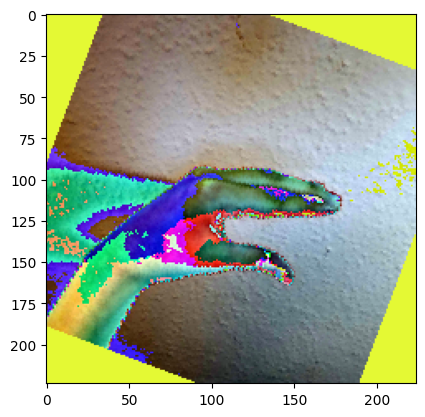

In [15]:
#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=combined_train_dataset.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])



In [16]:
# Check whether we have a GPU.  Use it if we do.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loader = torch.utils.data.DataLoader(dataset=combined_train_dataset,
                                          batch_size=10,
                                          shuffle=True)


def test(epoch):
    # Do one pass over the test data.
    # In the test phase, don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0
        accuracies = []
        losses = []
        for images, labels in test_loader:
            #Convert image pixels to vector
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images).squeeze((-1, -2))

            # Calculate loss
            loss = criterion(logits, labels)
            losses.append(loss.item())  # Append the loss to the list

            # Compute total correct so far
            predicted = torch.argmax(logits, -1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Calculate accuracy for the current batch
            batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracies.append(batch_accuracy)

        print(f'Test accuracy : {100 * correct / total} %')

        # Plot accuracy graph
        plt.plot(accuracies)
        plt.title('Accuracy Over Test Set Batches')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.show()

        # Plot loss graph
        plt.plot(losses)
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Loss Over Test Set Batches')
        plt.show()


    return total

# Run training
total = test(1)
print(total)

KeyboardInterrupt: 

# 8. Summary and Resources

You made it, Thanks for completing the notebook.  
* In this notebook we learned how to do the whole process of model building and training on notebook leveraging the power GPU environment to train deep learning models.
* Don't forget to get back and try different parameters or different models.

## Resources
* <a href="https://dataplatform.cloud.ibm.com/gallery">Other Great notebooks.</a>  
* <a href="https://www.python.org/">Official Python website.</a>  
* <a href="https://pytorch.org/">Official PyTorch website</a>  
* <a href="https://cloud.ibm.com/registration">Get started today on IBM Cloud for free!</a>   
* <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/gpu-environments.html">Learn more about GPU environments.</a>   

## Author

Mostafa Abdelaleem is a Developer Advocate at IBM who contributes to AI and data science community in order to democratize them.

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.